X_vectorized.shape: (1756, 51)
X_vectorized array length: 1756
X_transformed.shape: (1756, 52)
X_vectorized.shape: (1172, 51)
X_vectorized array length: 1172
X_transformed.shape: (1172, 52)

 
Model comparison -------------------
RandomForestClassifier Hyperparams
	 bootstrap = True ,
	 ccp_alpha = 0.0 ,
	 class_weight = balanced ,
	 criterion = log_loss ,
	 max_depth = 13 ,
	 max_features = log2 ,
	 max_leaf_nodes = None ,
	 max_samples = None ,
	 min_impurity_decrease = 0.0 ,
	 min_samples_leaf = 1 ,
	 min_samples_split = 3 ,
	 min_weight_fraction_leaf = 0.0 ,
	 n_estimators = 420 ,
	 n_jobs = -1 ,
	 oob_score = False ,
	 random_state = None ,
	 verbose = 0 ,
	 warm_start = False ,


	 	 F1 score:  0.533212477959957
	 	 0.53 accuracy with a standard deviation of 0.03
	 	 ROC AUC score:  0.7108220830394365 

LogisticRegression Hyperparams
	 C = 0.01 ,
	 class_weight = balanced ,
	 dual = False ,
	 fit_intercept = True ,
	 intercept_scaling = 1 ,
	 l1_ratio = None ,
	 max_iter = 120 ,


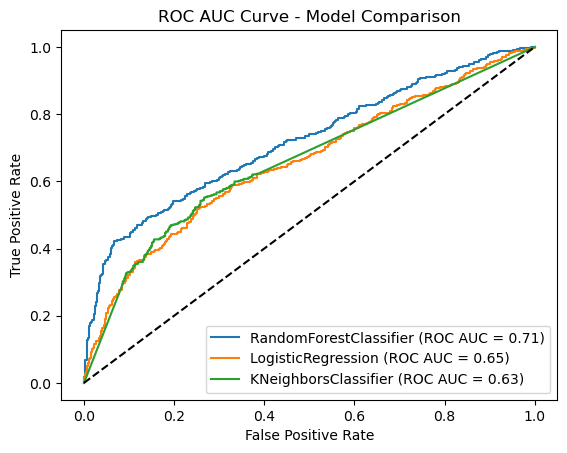

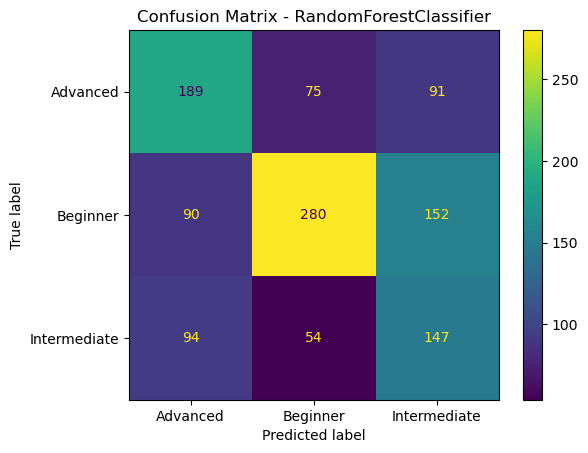

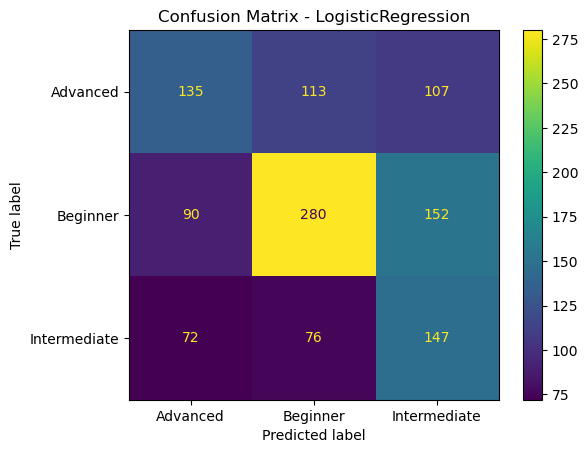

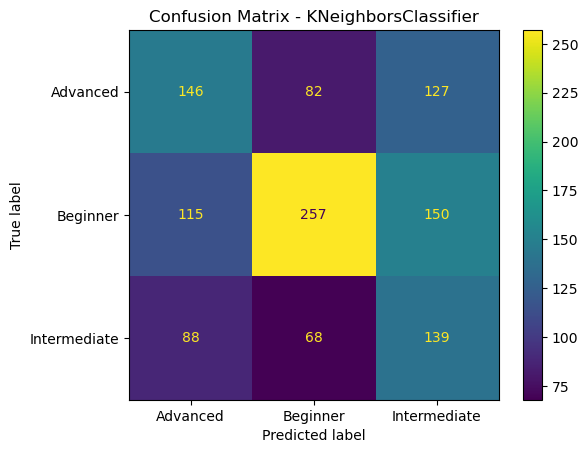

In [38]:
# https://www.projectpro.io/recipes/compare-sklearn-classification-algorithms-in-python

import warnings
import sys, os
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
#     os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses


def getDataframeXyAndLabelEncoder(data):
    # Convert data into a dataframe
    df = pd.DataFrame(data)

    # Encode the "University" column into numerical values
    label_encoder = LabelEncoder()
    df["University"] = label_encoder.fit_transform(df["University"])

    # Create a separate dataframe for the "University" column
    df_university = pd.DataFrame(df["University"])

    # Generate a new dataset by merging three columns
    X = df["Course_Name"] + " " + df["Course_Description"] + " " + df["Skills"]
    X = pd.DataFrame(X)
    X = X.rename(columns={0: "Name_Description_Skills"})

    # Vectorize the text data using CountVectorizer
    count_vect = CountVectorizer(max_features=51, ngram_range=(1, 2), lowercase=True)
    X_vectorized = count_vect.fit_transform(X["Name_Description_Skills"])

    # Print the shape of the vectorized data
    print("X_vectorized.shape:", X_vectorized.shape)
    print("X_vectorized array length:", len(X_vectorized.toarray()))

    # Convert the vectorized data into a dataframe
    X_vectorized_array = X_vectorized.toarray()
    X_vectorized_df = pd.DataFrame(X_vectorized_array)

    # Rename columns of the dataframe created from CountVectorizer
    X_vectorized_df.columns = X_vectorized_df.columns.astype(str)

    # Add the "University" column back to the dataframe
    X_vectorized_df.insert(0, "University", df_university, True)

    X_transformed = X_vectorized_df

    # Print the shape of the transformed data
    print("X_transformed.shape:", X_transformed.shape)

    # Encode the target labels to numerical values
    label_encoder = LabelEncoder()
    df["Difficulty_Level_Encoded"] = label_encoder.fit_transform(df["Difficulty_Level"])
    y_encoded = df["Difficulty_Level_Encoded"]

    return X_transformed, y_encoded, label_encoder


# read the data from storage
data_from_train_dataset = pd.read_csv("train.csv", sep=";", encoding="latin-1")

# prepare data
X_train_transformed, y_train, label_encoder = getDataframeXyAndLabelEncoder(
    data_from_train_dataset
)

# read the data from storage
data_from_test_dataset = pd.read_csv("test.csv", sep=";", encoding="latin-1")

# prepare data
X_test_transformed, y_test, label_encoder = getDataframeXyAndLabelEncoder(
    data_from_test_dataset
)

# Create instances of each model you want to compare.
models = [
    RandomForestClassifier(
        n_estimators=420,
        criterion="log_loss",
        max_depth=13,
        min_samples_split=3,
        min_samples_leaf=1,
        max_features="log2",
        n_jobs=-1,
        class_weight="balanced",
        ccp_alpha=0.0,
        # verbose=1,
    ),
    LogisticRegression(
        C=0.01,
        class_weight="balanced",
        fit_intercept=True,
        max_iter=120,
        multi_class="ovr",
        n_jobs=-1,
        penalty="l2",
        solver="lbfgs",
        # verbose=1,
    ),
    KNeighborsClassifier(
        algorithm="auto",
        leaf_size=34,
        metric="manhattan",
        n_jobs=-1,
        n_neighbors=2,
        p=2,
        weights="distance",
    ),
]

# shuffle=True: This parameter determines whether the data should be shuffled before splitting into folds. By setting it to True, the data will be shuffled randomly before creating the folds. Shuffling the data can be beneficial to avoid any ordering or sequence bias in the dataset.
# random_state=50: This parameter sets the random seed for reproducibility. By specifying a particular value, in this case, 42, the randomization will be controlled, and the same random splits will be generated each time the code is run with the same seed value. This ensures consistency and allows for fair comparison of different models.
# Perform cross-validation for each model using the same folds
# Define StratifiedKFold with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store performance measures and confusion matrix
model_names = []
roc_auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
macro_avg_roc_auc_scores = []
class_roc_auc_scores = []
weighted_avg_roc_auc_scores = []
models_confusion_matrix = []


print("\n \nModel comparison -------------------")
# Iterate over each model and evaluate its performance
for model in models:
    print(model.__class__.__name__, "Hyperparams")

    # Print the model hyperparameters
    params = model.get_params()
    for key, value in params.items():
        print("\t {} = {}".format(key, value), ",")
    print("\n")

    # to avoid data leakage across folds, perform all the steps of pipeline in each fold
    # Create a pipeline with SMOTE oversampling, scaling, and the classifier
    pipe = Pipeline(
        steps=[
            ("smote", SMOTE(random_state=42)),
            ("standardscaler", StandardScaler()),
            ("model", model),
        ]
    )

    # Fit the model on the training data
    # clf = model.fit(X_train_transformed, y_train)
    clf = pipe.fit(X_train_transformed, y_train)

    # Predict on the test data
    y_pred = clf.predict(X_test_transformed)

    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred, average="weighted")
    print("\t \t F1 score: ", f1)

    # Perform cross-validation and calculate the F1 score
    # cross validation using intra-fold sampling
    scoring = {"f1": make_scorer(f1_score, average="weighted")}
    scores = cross_val_score(
        clf,
        X_train_transformed,
        y_train,
        cv=skf,
        scoring=scoring["f1"],
        error_score="raise",
        n_jobs=-1,
    )
    print(
        "\t \t %0.2f accuracy with a standard deviation of %0.2f"
        % (scores.mean(), scores.std())
    )

    # Get the predicted probabilities for each class on the test set
    y_scores = clf.predict_proba(X_test_transformed)

    # Calculate the ROC AUC score
    roc_auc = roc_auc_score(y_test, y_scores, multi_class="ovr")
    print("\t \t ROC AUC score: ", roc_auc, "\n")

    # Store the model name and ROC AUC score
    model_names.append(model.__class__.__name__)
    roc_auc_scores.append(roc_auc)

    # Calculate and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    models_confusion_matrix.append((model.__class__.__name__, cm))

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1], pos_label=1)
    plt.plot(
        fpr,
        tpr,
        label="{} (ROC AUC = {:.2f})".format(model.__class__.__name__, roc_auc),
    )

# Set plot title and labels
plt.title("ROC AUC Curve - Model Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
# Add a legend
plt.legend()
# Show the plot
plt.show()

# Plot the confusion matrix for each model
for model_name, cm in models_confusion_matrix:
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=label_encoder.classes_
    )
    disp.plot()
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()